# Leash Bio - Predict New Medicines with BELKA

## Introduction
Small molecule drugs play a crucial role in modern medicine, often targeting specific proteins to treat various diseases. However, with a vast chemical space to explore, traditional drug discovery methods can be laborious and time-consuming. The Leash Bio competition, "Predict New Medicines with BELKA," aims to revolutionize small molecule binding prediction by leveraging machine learning techniques.

## Dataset Overview
The competition dataset comprises binary classifications indicating whether a small molecule binds to one of three protein targets. The data were collected using DNA-encoded chemical library (DEL) technology. Each example includes SMILES representations of building blocks and the fully assembled molecule, along with protein target names and binary binding classifications.

### Files
- **train/test.[csv/parquet]:** Contains training or test data in both csv and parquet formats.
  - `id`: Unique identifier for the molecule-binding target pair.
  - `buildingblock1_smiles`, `buildingblock2_smiles`, `buildingblock3_smiles`: SMILES representations of building blocks.
  - `molecule_smiles`: SMILES representation of the fully assembled molecule.
  - `protein_name`: Name of the protein target.
  - `binds`: Binary class label indicating whether the molecule binds to the protein (not available for the test set).
- **sample_submission.csv:** Sample submission file in the correct format.

### Competition Data
Leash Biosciences provides approximately 98M training examples per protein, 200K validation examples per protein, and 360K test molecules per protein. The test set contains building blocks not present in the training set, ensuring generalizability. The datasets are highly imbalanced, with only about 0.5% of examples classified as binders.

## Protein Targets
The competition focuses on predicting binding affinity for three protein targets:

1. **EPHX2 (sEH):** Encoded by the EPHX2 genetic locus, soluble epoxide hydrolase (sEH) is a potential drug target for conditions like high blood pressure and diabetes. Crystal structures and amino acid sequences are provided for contestants wishing to incorporate protein structural information.
2. **BRD4:** Bromodomain 4 plays roles in cancer progression, and inhibiting its activity is a strategy for cancer treatment. Crystal structures and sequences are available for contestants.
3. **ALB (HSA):** Human serum albumin (HSA) is the most common protein in blood and plays a crucial role in drug absorption and transport. Predicting ALB binding can greatly impact drug discovery across various diseases.

<table>
  <tr>
      <th><h2>Protein Name</h2></th>
      <th><h2>Structure</h2></th>
  </tr>
  <tr>
      <td><h2>EPHX2 (sEH)</h2></td>
    <td><img src="https://cdn1.sinobiological.com/styles/default/images/protein-structure/CTSS-protein-structure.jpg" alt="EPHX2 (sEH) protein structure" width="500" height="500"></td>
  </tr>
  <tr>
      <td><h2>BRD4</h2></td>
    <td><img src="https://www.pinclipart.com/picdir/big/70-700834_protein-brd4-pdb-2oss-by-emw-brd4-protein.png" alt="BRD4 protein structure" width="500" height="500"></td>
  </tr>
  <tr>
      <td><h2>ALB (HSA)</h2></td>
    <td><img src="https://cdn.rcsb.org/images/structures/1e78_assembly-1.jpeg" alt="ALB (HSA) protein structure" width="500" height="500"></td>
  </tr>
</table>

In [1]:
!pip install duckdb
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 27.0 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import duckdb
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import os

In [3]:
# Establish connection to DuckDB
con = duckdb.connect()

# Define file paths
train_path = '/kaggle/input/leash-BELKA/train.parquet'
test_file = '/kaggle/input/leash-BELKA/test.csv'
output_file = 'submission.csv'

# Load training data from parquet file into DataFrame
df = con.query(f"""(SELECT *
                    FROM parquet_scan('{train_path}')
                    WHERE binds = 0
                    ORDER BY random()
                    LIMIT 90000)
                    UNION ALL
                    (SELECT *
                    FROM parquet_scan('{train_path}')
                    WHERE binds = 1
                    ORDER BY random()
                    LIMIT 90000)""").df()

# Close connection
con.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [4]:
# Define function to generate ECFP
def generate_ecfp(molecule, radius=2, bits=1024):
    if molecule is None:
        return None
    return list(AllChem.GetMorganFingerprintAsBitVect(molecule, radius, nBits=bits))

In [5]:
# Convert SMILES to RDKit molecules and generate ECFPs
df['molecule'] = df['molecule_smiles'].apply(Chem.MolFromSmiles)
df['ecfp'] = df['molecule'].apply(generate_ecfp)

# One-hot encode the protein_name
onehot_encoder = OneHotEncoder(sparse_output=False)
protein_onehot = onehot_encoder.fit_transform(df['protein_name'].values.reshape(-1, 1))

# Combine ECFPs and one-hot encoded protein_name
X = [ecfp + protein for ecfp, protein in zip(df['ecfp'].tolist(), protein_onehot.tolist())]
y = df['binds'].tolist()

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Train Decision Tree model
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

# Train XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Train CatBoost model
cat_model = CatBoostClassifier()
cat_model.fit(X_train, y_train)

# Train KNN model
KNN_model = KNeighborsClassifier()
KNN_model.fit(X_train, y_train)

Learning rate set to 0.086011
0:	learn: 0.6606693	total: 138ms	remaining: 2m 17s
1:	learn: 0.6361084	total: 214ms	remaining: 1m 46s
2:	learn: 0.6148079	total: 285ms	remaining: 1m 34s
3:	learn: 0.5963335	total: 370ms	remaining: 1m 32s
4:	learn: 0.5784513	total: 449ms	remaining: 1m 29s
5:	learn: 0.5632743	total: 519ms	remaining: 1m 25s
6:	learn: 0.5519382	total: 596ms	remaining: 1m 24s
7:	learn: 0.5429821	total: 669ms	remaining: 1m 22s
8:	learn: 0.5367300	total: 733ms	remaining: 1m 20s
9:	learn: 0.5294362	total: 798ms	remaining: 1m 18s
10:	learn: 0.5227808	total: 879ms	remaining: 1m 19s
11:	learn: 0.5169761	total: 948ms	remaining: 1m 18s
12:	learn: 0.5104997	total: 1.02s	remaining: 1m 17s
13:	learn: 0.5039559	total: 1.09s	remaining: 1m 16s
14:	learn: 0.4990944	total: 1.16s	remaining: 1m 15s
15:	learn: 0.4930952	total: 1.23s	remaining: 1m 15s
16:	learn: 0.4891610	total: 1.3s	remaining: 1m 15s
17:	learn: 0.4862874	total: 1.36s	remaining: 1m 14s
18:	learn: 0.4818196	total: 1.43s	remaining: 

KNeighborsClassifier()

In [7]:
# Make predictions on the test set for each model
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
y_pred_prob_dt = dt_model.predict_proba(X_test)[:, 1]
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_pred_proba_cat = cat_model.predict_proba(X_test)[:, 1]
y_pred_proba_KNN = KNN_model.predict_proba(X_test)[:, 1]

# Calculate mean average precision for each model
rf_score = average_precision_score(y_test, y_pred_proba_rf)
dt_score = average_precision_score(y_test, y_pred_prob_dt)
xgb_score = average_precision_score(y_test, y_pred_proba_xgb)
cat_score = average_precision_score(y_test, y_pred_proba_cat)
knn_score = average_precision_score(y_test, y_pred_proba_KNN)

# Create a bar plot comparing mean average precision of models
models = ['Random Forest', 'Decision Trees', 'XGBoost', 'CatBoost', 'KNN']
accuracy_scores = [rf_score, dt_score, xgb_score, cat_score, knn_score]

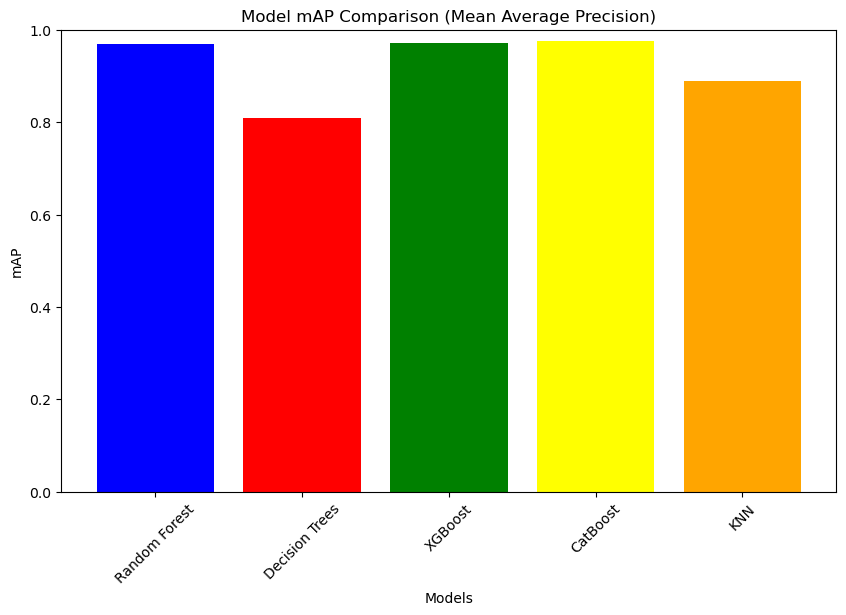

In [8]:
plt.figure(figsize=(10, 6))
plt.bar(models, accuracy_scores, color=['blue', 'red', 'green', 'yellow', 'orange'])
plt.xlabel('Models')
plt.ylabel('mAP')
plt.title('Model mAP Comparison (Mean Average Precision)')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

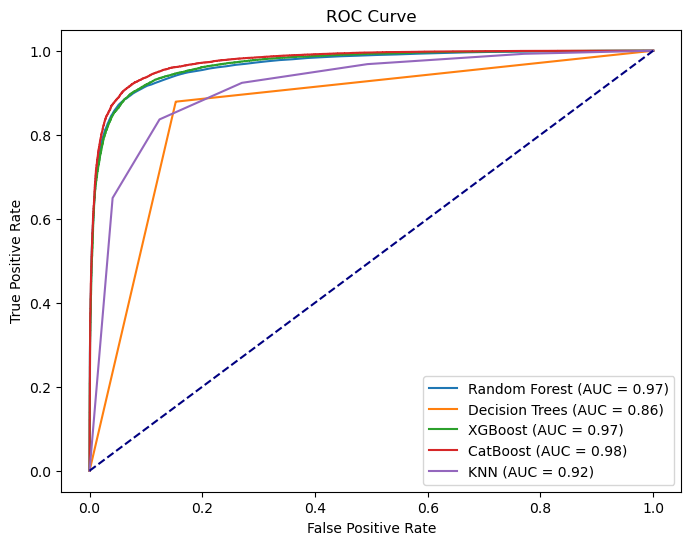

Random Forest:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     17990
           1       0.94      0.88      0.91     18010

    accuracy                           0.91     36000
   macro avg       0.91      0.91      0.91     36000
weighted avg       0.91      0.91      0.91     36000

Decision Trees:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     17990
           1       0.85      0.88      0.87     18010

    accuracy                           0.86     36000
   macro avg       0.86      0.86      0.86     36000
weighted avg       0.86      0.86      0.86     36000

XGBoost:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     17990
           1       0.93      0.89      0.91     18010

    accuracy                           0.91     36000
   macro avg       0.91      0.91      0.91     36000
weighted avg       0.91      0.91 

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report

# Calculate ROC-AUC score for each model
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
roc_auc_dt = roc_auc_score(y_test, y_pred_prob_dt)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
roc_auc_cat = roc_auc_score(y_test, y_pred_proba_cat)
roc_auc_knn = roc_auc_score(y_test, y_pred_proba_KNN)

# Plot the ROC-AUC curve
plt.figure(figsize=(8, 6))
plt.plot(*roc_curve(y_test, y_pred_proba_rf)[:2], label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(*roc_curve(y_test, y_pred_prob_dt)[:2], label=f'Decision Trees (AUC = {roc_auc_dt:.2f})')
plt.plot(*roc_curve(y_test, y_pred_proba_xgb)[:2], label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot(*roc_curve(y_test, y_pred_proba_cat)[:2], label=f'CatBoost (AUC = {roc_auc_cat:.2f})')
plt.plot(*roc_curve(y_test, y_pred_proba_KNN)[:2], label=f'KNN (AUC = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate accuracy and loss for each model
accuracy_rf = accuracy_score(y_test, (y_pred_proba_rf > 0.5).astype(int))
accuracy_dt = accuracy_score(y_test, (y_pred_prob_dt > 0.5).astype(int))
accuracy_xgb = accuracy_score(y_test, (y_pred_proba_xgb > 0.5).astype(int))
accuracy_cat = accuracy_score(y_test, (y_pred_proba_cat > 0.5).astype(int))
accuracy_knn = accuracy_score(y_test, (y_pred_proba_KNN > 0.5).astype(int))

# Print classification report
print("Random Forest:")
print(classification_report(y_test, (y_pred_proba_rf > 0.5).astype(int)))
print("Decision Trees:")
print(classification_report(y_test, (y_pred_prob_dt > 0.5).astype(int)))
print("XGBoost:")
print(classification_report(y_test, (y_pred_proba_xgb > 0.5).astype(int)))
print("CatBoost:")
print(classification_report(y_test, (y_pred_proba_cat > 0.5).astype(int)))
print("KNN:")
print(classification_report(y_test, (y_pred_proba_KNN > 0.5).astype(int)))

In [10]:
# Process the test.parquet file chunk by chunk
for df_test in pd.read_csv(test_file, chunksize=100000):
    # Generate ECFPs for the molecule_smiles
    df_test['molecule'] = df_test['molecule_smiles'].apply(Chem.MolFromSmiles)
    df_test['ecfp'] = df_test['molecule'].apply(generate_ecfp)
    df_test.drop(["buildingblock1_smiles", "buildingblock2_smiles", "buildingblock3_smiles"], axis=1, inplace=True)

    # One-hot encode the protein_name
    protein_onehot = onehot_encoder.transform(df_test['protein_name'].values.reshape(-1, 1))

    # Combine ECFPs and one-hot encoded protein_name
    X_test = [ecfp + protein for ecfp, protein in zip(df_test['ecfp'].tolist(), protein_onehot.tolist())]

    # Make predictions using all models
    y_pred_rf = rf_model.predict_proba(X_test)[:, 1]
    y_pred_dt = dt_model.predict_proba(X_test)[:, 1]
    y_pred_xgb = xgb_model.predict_proba(X_test)[:, 1]
    y_pred_cat = cat_model.predict_proba(X_test)[:, 1]
    y_pred_knn = KNN_model.predict_proba(X_test)[:, 1]

    # Ensemble predictions (average)
    y_pred_ensemble = (y_pred_rf + y_pred_dt + y_pred_xgb + y_pred_cat + y_pred_knn) / 5.0

    # Create a DataFrame with 'id' and 'probability' columns
    output_df = pd.DataFrame({'id': df_test['id'], 'binds': y_pred_ensemble})

    # Save the output DataFrame to a CSV file
    output_df.to_csv(output_file, index=False, mode='a', header=not os.path.exists(output_file))